In [27]:
# !pip install instaloader
# !pip install google-cloud
# !pip install google-cloud-vision
# !pip install pyLDAvis

In [5]:
import instaloader
from instaloader import Profile
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from google.cloud import vision
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import os
import ast
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer 
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
#nltk.download('wordnet')
import pyLDAvis
import pyLDAvis.gensim 

In [ ]:
USERNAME = 'natgeo'

L = instaloader.Instaloader()
posts = instaloader.Profile.from_username(L.context, USERNAME).get_posts()

df = pd.DataFrame(columns=['post_link', 'comment_count','likes_count','caption','is_video','image_link'])
counter = 0

for post in posts:
    counter+=1
    shortcode = post.shortcode
    post_link = 'https://instagram.com/p/'+shortcode+'/'
    likes = post.likes
    comments = post.comments
    caption = post.caption
    video = post.is_video
    image_link = post.url


    df = df.append({'post_link':post_link, 'comment_count':comments, 'likes_count':likes, 'caption':caption,'image_link':image_link,'is_video':video}, ignore_index=True)
    if counter>=600:
        break
photo_df = df[df['is_video']==False] #selecting only the photos

In [ ]:
#photo_df.to_csv('natgeo_insta_photo_posts.csv')

In [3]:
photo_df = pd.read_csv('natgeo_insta_photo_posts.csv')
photo_df.head()

,Unnamed: 0,post_link,comment_count,likes_count,caption,is_video,image_link
0,0,https://instagram.com/p/B44MXP-gNxy/,209,79912,Photo by Keith Ladzinski @ladzinski | With a l...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/93c...
1,1,https://instagram.com/p/B433BqzAGIf/,685,178480,Photo by Cristina Mittermeier @Mitty | Did you...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/235...
2,2,https://instagram.com/p/B43ibepIaV0/,511,110287,Photo by @jodicobbphoto | Heartbreaking floods...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/ca0...
3,3,https://instagram.com/p/B43OGVdD9Rx/,525,253331,Photos by Stephen Alvarez @salvarezphoto | My ...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/d98...
4,4,https://instagram.com/p/B425rKvjVLJ/,826,141166,Photo by @dina_litovsky | These are portraits ...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/b7f...


# Task A: Engagement Metrics:

In [4]:
photo_df.loc[:,('comment_normal')] = photo_df['comment_count']/max(photo_df['comment_count']) #normalizing comment count

In [5]:
photo_df.loc[:,('likes_normal')] = photo_df.loc[:,('likes_count')]/max(photo_df['likes_count']) #normalizing likes count

In [6]:
# Engagement score = .4*# likes (normalized) + .6*# comments (normalized). 
photo_df.loc[:,('engagement_score')] = (0.4*photo_df.loc[:,('likes_normal')]) + (0.6*photo_df.loc[:,('comment_normal')])

In [7]:
#Assigning 1 and 0 to high and low engagement respectively
med = photo_df['engagement_score'].median()
photo_df['engagement'] = np.where(photo_df['engagement_score']>= med, 1, 0)

In [8]:
photo_df['engagement'].value_counts() # no. of high and low engagements

1    282
0    281
Name: engagement, dtype: int64

In [ ]:
#photo_df.to_csv('HW2_postTaskA.csv')

# Task B: Logistic Regression

### Getting Image Labels

In [4]:
photo_df=pd.read_csv('HW2_karan_postTaskA.csv',encoding = "ISO-8859-1")

In [5]:
photo_df=photo_df.reset_index(drop=True)
photo_df_temp=photo_df
photo_df_temp.head()
photo_df_temp=photo_df_temp.drop('Unnamed: 0',axis=1)

In [172]:
file_name=[]
labels=[]
image_paths = []
counter=0

"""Initialize Environment Variables to enable authentication with google Vision API"""
#os.environ[“GOOGLE_APPLICATION_CREDENTIALS”]=“/Users/maverick/Downloads/TextAnalyticsHW2-7a4808cb2b6c.json”


for each_img in photo_df_temp.image_link:
    image_paths.append(each_img)
    file_name.append(str(photo_df_temp.image_link.index[counter]+1) + ".jpg")
    counter+=1

client = vision.ImageAnnotatorClient()
image = vision.types.Image()   

def getlabelsforRemoteImage(uri):
    """Detects labels in the file located in Google Cloud Storage or on the
    Web."""
    labels_list=[]
    image.source.image_uri = uri

    response = client.label_detection(image=image)
    labels = response.label_annotations
    
    for label in labels:
        labels_list.append(label.description)
    print(uri)
    print(labels_list)
    return(labels_list)

for i in image_paths:
    labels.append(getlabelsforRemoteImage(i))    

https://instagram.fftw1-1.fna.fbcdn.net/vp/93c8f2f32d42d97bf8cc321e1c51cc92/5E578C9F/t51.2885-15/fr/e15/p1080x1080/73524873_165211074563089_7996976285211762353_n.jpg?_nc_ht=instagram.fftw1-1.fna.fbcdn.net&_nc_cat=1
['Tree', 'Sky', 'Blue', 'Woody plant', 'Plant', 'Night', 'Branch', 'Trunk', 'Electric blue', 'Midnight']
https://instagram.fftw1-1.fna.fbcdn.net/vp/235a1d2345935f6b124c96745b56d77a/5E892863/t51.2885-15/fr/e15/s1080x1080/75311724_143760720260814_3090049339357191194_n.jpg?_nc_ht=instagram.fftw1-1.fna.fbcdn.net&_nc_cat=1
['People in nature', 'Photograph', 'Black', 'Black-and-white', 'Photography', 'Male', 'Monochrome photography', 'Rock', 'Arm', 'Human']
https://instagram.fftw1-1.fna.fbcdn.net/vp/ca0050f10599ed57a8cc23dd2013caa8/5E57CBB0/t51.2885-15/fr/e15/s1080x1080/75265143_438622817034285_5208185565625202041_n.jpg?_nc_ht=instagram.fftw1-1.fna.fbcdn.net&_nc_cat=1
['Reflection', 'Water', 'Reflecting pool', 'Architecture', 'Symmetry', 'River', 'Water feature']
https://instagram

In [173]:
photo_df_temp['labels']=pd.Series(labels)    
photo_df_temp['labels']

0      [Tree, Sky, Blue, Woody plant, Plant, Night, B...
1      [People in nature, Photograph, Black, Black-an...
2      [Reflection, Water, Reflecting pool, Architect...
3      [Sky, Galaxy, Night, Astronomical object, Atmo...
4      [Lady, Beauty, Lip, Fashion, Photo shoot, Arm,...
5      [Visual effect lighting, Technology, Display d...
6      [Tiger, Wildlife, Vertebrate, Bengal tiger, Si...
7      [Wave, Ocean, Surfing Equipment, Surfing, Sea,...
8      [Water, Nature, Black-and-white, Atmospheric p...
9      [Army, Soldier, Military, Military uniform, Tr...
10     [Arctic, Glacial landform, Natural environment...
11     [Orange, Silhouette, Yellow, Backlighting, Pho...
12     [Face, Facial expression, Wrinkle, Forehead, S...
13     [Grass, Pasture, Wildlife, Grass family, Grass...
14                         [Adventure, Recreation, Fawn]
15     [Design, Textile, Colorfulness, Pattern, Photo...
16     [Hair, Face, Beauty, Lip, Lady, Hairstyle, Smi...
17     [Mammal, Hyena, Vertebra

In [13]:
photo_df_temp['labels']=pd.Series(labels)    
photo_df_temp['labels']

0      ['Tree', 'Sky', 'Blue', 'Woody plant', 'Plant'...
1      ['People in nature', 'Photograph', 'Black', 'B...
2      ['Reflection', 'Water', 'Reflecting pool', 'Ar...
3      ['Sky', 'Galaxy', 'Night', 'Astronomical objec...
4      ['Lady', 'Beauty', 'Lip', 'Fashion', 'Photo sh...
5      ['Visual effect lighting', 'Technology', 'Disp...
6      ['Tiger', 'Wildlife', 'Vertebrate', 'Bengal ti...
7      ['Wave', 'Ocean', 'Surfing Equipment', 'Surfin...
8      ['Water', 'Nature', 'Black-and-white', 'Atmosp...
9      ['Army', 'Soldier', 'Military', 'Military unif...
10     ['Arctic', 'Glacial landform', 'Natural enviro...
11     ['Orange', 'Silhouette', 'Yellow', 'Backlighti...
12     ['Face', 'Facial expression', 'Wrinkle', 'Fore...
13     ['Grass', 'Pasture', 'Wildlife', 'Grass family...
14                   ['Adventure', 'Recreation', 'Fawn']
15     ['Design', 'Textile', 'Colorfulness', 'Pattern...
16     ['Hair', 'Face', 'Beauty', 'Lip', 'Lady', 'Hai...
17     ['Mammal', 'Hyena', 'Ver

In [ ]:
#photo_df_temp.to_csv('with_labels.csv') #saving the labels to csv

In [8]:
photo_df_temp = pd.read_csv('with_labels.csv',encoding='utf-8')
photo_df_temp.head()

,Unnamed: 0,Unnamed: 0.1,post_link,comment_count,likes_count,caption,is_video,image_link,comment_normal,likes_normal,engagement_score,engagement,labels
0,0,0,https://instagram.com/p/B44MXP-gNxy/,209,79912,Photo by Keith Ladzinski @ladzinski | With a l...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/93c...,0.003661,0.033486,0.015591,0,"['Tree', 'Sky', 'Blue', 'Woody plant', 'Plant'..."
1,1,1,https://instagram.com/p/B433BqzAGIf/,685,178480,Photo by Cristina Mittermeier @Mitty | Did you...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/235...,0.011998,0.074790,0.037115,0,"['People in nature', 'Photograph', 'Black', 'B..."
2,2,2,https://instagram.com/p/B43ibepIaV0/,511,110287,Photo by @jodicobbphoto | Heartbreaking floods...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/ca0...,0.008950,0.046214,0.023856,0,"['Reflection', 'Water', 'Reflecting pool', 'Ar..."
3,3,3,https://instagram.com/p/B43OGVdD9Rx/,525,253331,Photos by Stephen Alvarez @salvarezphoto | My ...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/d98...,0.009196,0.106155,0.047979,0,"['Sky', 'Galaxy', 'Night', 'Astronomical objec..."
4,4,4,https://instagram.com/p/B425rKvjVLJ/,826,141166,Photo by @dina_litovsky | These are portraits ...,False,https://instagram.fftw1-1.fna.fbcdn.net/vp/b7f...,0.014468,0.059154,0.032342,0,"['Lady', 'Beauty', 'Lip', 'Fashion', 'Photo sh..."


### Logistic Regression with Engagement 

In [28]:
def classify(doce):

    X_train, X_test, y_train,y_test = train_test_split(doce,photo_df_temp['engagement'] ,test_size= 0.2, random_state=18)
    
    """initialize TFIDFVectorizer"""
    tfidf_vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)

    fitted_vectorizer=tfidf_vectorizer.fit(X_train)
    tfidf_vectorizer_vectors=fitted_vectorizer.transform(X_train)

    test_features = tfidf_vectorizer.transform(X_test)

    """call the labels one column at a time so we can run the classifier on them"""
    train_target = y_train
    test_target = y_test
    classifier = LogisticRegression(solver='sag', C=10)

    y_train= y_train.astype('int')
    y_test = y_test.astype('int')

    classifier=classifier.fit(tfidf_vectorizer_vectors, train_target)
    
    """Predict Classifier on Test Data"""
    y_pred=classifier.predict(test_features)
    print("Confusion Matrix is : ")
    print(confusion_matrix(test_target, y_pred))
    print()
    print("Classification Report is : ")
    print(classification_report(test_target, y_pred))

In [24]:
 photo_df_temp['labels']

0      ['Tree', 'Sky', 'Blue', 'Woody plant', 'Plant'...
1      ['People in nature', 'Photograph', 'Black', 'B...
2      ['Reflection', 'Water', 'Reflecting pool', 'Ar...
3      ['Sky', 'Galaxy', 'Night', 'Astronomical objec...
4      ['Lady', 'Beauty', 'Lip', 'Fashion', 'Photo sh...
5      ['Visual effect lighting', 'Technology', 'Disp...
6      ['Tiger', 'Wildlife', 'Vertebrate', 'Bengal ti...
7      ['Wave', 'Ocean', 'Surfing Equipment', 'Surfin...
8      ['Water', 'Nature', 'Black-and-white', 'Atmosp...
9      ['Army', 'Soldier', 'Military', 'Military unif...
10     ['Arctic', 'Glacial landform', 'Natural enviro...
11     ['Orange', 'Silhouette', 'Yellow', 'Backlighti...
12     ['Face', 'Facial expression', 'Wrinkle', 'Fore...
13     ['Grass', 'Pasture', 'Wildlife', 'Grass family...
14                   ['Adventure', 'Recreation', 'Fawn']
15     ['Design', 'Textile', 'Colorfulness', 'Pattern...
16     ['Hair', 'Face', 'Beauty', 'Lip', 'Lady', 'Hai...
17     ['Mammal', 'Hyena', 'Ver

In [23]:
label_document=[]

"""generate array of labels"""
for each_label in photo_df_temp['labels']:
    label='' 
    label=label+ each_label + ' '
    label_document.append(label)  


classify(label_document)

Confusion Matrix is : 
[[44 16]
 [ 9 44]]

Classification Report is : 
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        60
           1       0.73      0.83      0.78        53

    accuracy                           0.78       113
   macro avg       0.78      0.78      0.78       113
weighted avg       0.78      0.78      0.78       113



In [25]:
caption_document=[]

for each_caption in photo_df_temp['caption']:
    caption='' 
    caption=caption+ each_caption + ' '
    caption_document.append(caption)  

"""Run classification on Captions"""
classify(caption_document)

Confusion Matrix is : 
[[46 14]
 [ 6 47]]

Classification Report is : 
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        60
           1       0.77      0.89      0.82        53

    accuracy                           0.82       113
   macro avg       0.83      0.83      0.82       113
weighted avg       0.83      0.82      0.82       113



In [29]:
"""Function to attach caption and labels"""

def get_label(row):
    label_document=''
    for each_word in row:
        label_document= label_document+ ' ' + each_word 
    return label_document 

photo_df_temp['labels']=photo_df_temp['labels'].apply(get_label)
photo_df_temp['caption_label']=photo_df_temp['caption'] + photo_df_temp['labels']

In [30]:
caption_label_document=[]
for each_caption in photo_df_temp['caption_label']:
    caption='' 
    caption=caption+ each_caption + ' '
    caption_label_document.append(caption)  

"""Run classification on caption and labels"""
classify(caption_label_document)

Confusion Matrix is : 
[[46 14]
 [ 6 47]]

Classification Report is : 
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        60
           1       0.77      0.89      0.82        53

    accuracy                           0.82       113
   macro avg       0.83      0.83      0.82       113
weighted avg       0.83      0.82      0.82       113



# Part C - Topic Modeling (LDA)

In [2]:
df = pd.read_csv('with_labels.csv', error_bad_lines=False)
#df=photo_df_temp

In [4]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

data_labels = df[['labels']]
data_labels['index'] = data_labels.index
print(len(data_labels))
data_labels[:10]

563


C:\Users\Karan Palsani\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,labels,index
0,"['Tree', 'Sky', 'Blue', 'Woody plant', 'Plant'...",0
1,"['People in nature', 'Photograph', 'Black', 'B...",1
2,"['Reflection', 'Water', 'Reflecting pool', 'Ar...",2
3,"['Sky', 'Galaxy', 'Night', 'Astronomical objec...",3
4,"['Lady', 'Beauty', 'Lip', 'Fashion', 'Photo sh...",4
5,"['Visual effect lighting', 'Technology', 'Disp...",5
6,"['Tiger', 'Wildlife', 'Vertebrate', 'Bengal ti...",6
7,"['Wave', 'Ocean', 'Surfing Equipment', 'Surfin...",7
8,"['Water', 'Nature', 'Black-and-white', 'Atmosp...",8
9,"['Army', 'Soldier', 'Military', 'Military unif...",9


## Stemming, Lemmatizing and Pre-processing 

In [6]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
doc_sample = data_labels[data_labels['index'] == 200].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

processed_docs = data_labels['labels'].map(preprocess)
processed_docs[:10]

original document: 
["['Field',", "'Crop',", "'Agriculture',", "'Plantation',", "'Farm',", "'Cash", "crop',", "'Sky',", "'Morning',", "'Plant',", "'Rural", "area']"]


 tokenized and lemmatized document: 
['field', 'crop', 'agriculture', 'plantation', 'farm', 'cash', 'crop', 'sky', 'morning', 'plant', 'rural', 'area']


0    [tree, sky, blue, woody, plant, plant, night, ...
1    [people, nature, photograph, black, black, whi...
2    [reflection, water, reflect, pool, architectur...
3    [sky, galaxy, night, astronomical, object, atm...
4    [lady, beauty, lip, fashion, photo, shoot, arm...
5    [visual, effect, light, technology, display, d...
6    [tiger, wildlife, vertebrate, bengal, tiger, s...
7    [wave, ocean, surf, equipment, surf, sea, surf...
8    [water, nature, black, white, atmospheric, phe...
9    [army, soldier, military, military, uniform, t...
Name: labels, dtype: object

## Bag of words 

In [8]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 blue
1 branch
2 electric
3 midnight
4 night
5 plant
6 sky
7 tree
8 trunk
9 woody
10 arm


In [9]:
dictionary.filter_extremes(no_below=7, no_above=0.5, keep_n=100000)

#### Gensim doc2bow 

In [10]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[310]

processed_docs[310]

#To output words and their corresponding frequency

#bow_doc_310 = bow_corpus[310]
#for i in range(len(bow_doc_310)):
    #print("Word {} (\"{}\") appears {} time.".format(bow_doc_310[i][0], 
     #                                          dictionary[bow_doc_310[i][0]], 
#bow_doc_310[i][1]))
#

['sky',
 'pasture',
 'nature',
 'horse',
 'grassland',
 'graze',
 'natural',
 'landscape',
 'natural',
 'environment',
 'grass',
 'cloud']

### Running LDA using bag of words 

In [11]:
np.random.seed(2020)
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=8, workers=2)

In [12]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.074*"water" + 0.070*"sea" + 0.049*"natural" + 0.038*"sky" + 0.034*"fish" + 0.032*"ocean" + 0.032*"marine" + 0.031*"turtle" + 0.031*"environment" + 0.025*"underwater"
Topic: 1 
Words: 0.059*"wildlife" + 0.047*"animal" + 0.040*"plant" + 0.038*"terrestrial" + 0.038*"photography" + 0.032*"vertebrate" + 0.030*"tree" + 0.029*"bird" + 0.025*"elephant" + 0.025*"mammal"
Topic: 2 
Words: 0.062*"photography" + 0.039*"fun" + 0.035*"human" + 0.035*"people" + 0.034*"adaptation" + 0.033*"event" + 0.032*"dog" + 0.026*"smile" + 0.026*"child" + 0.025*"room"
Topic: 3 
Words: 0.085*"sky" + 0.051*"phenomenon" + 0.042*"mountain" + 0.038*"landscape" + 0.029*"atmospheric" + 0.029*"light" + 0.028*"night" + 0.026*"landforms" + 0.025*"atmosphere" + 0.025*"mountainous"


### Top-10 words loaded for each topic

In [13]:
x=lda_model.show_topics()

def Convert(string): 
    li = list(string.split("  ")) 
    return li 

twords={}
for topic,word in x:
    twords[topic]=Convert(re.sub('[^A-Za-z ]+','', word))
    print('Topic words:',topic,'\nWords:',twords[topic])
    
terms_df = pd.DataFrame([twords])
terms_df = terms_df.transpose()
terms_df.index.name = 'Topic'
terms_df.columns = ['Words']
terms_df.to_csv('words_loading_on_topics.csv')

Topic words: 0 
Words: ['water', 'sea', 'natural', 'sky', 'fish', 'ocean', 'marine', 'turtle', 'environment', 'underwater']
Topic words: 1 
Words: ['wildlife', 'animal', 'plant', 'terrestrial', 'photography', 'vertebrate', 'tree', 'bird', 'elephant', 'mammal']
Topic words: 2 
Words: ['photography', 'fun', 'human', 'people', 'adaptation', 'event', 'dog', 'smile', 'child', 'room']
Topic words: 3 
Words: ['sky', 'phenomenon', 'mountain', 'landscape', 'atmospheric', 'light', 'night', 'landforms', 'atmosphere', 'mountainous']


## Performance Evaluation 

#### This was for manual verification wherein we changed index number everytime manually and checked topic generated for a set of labels

In [14]:
processed_docs[300]

['people',
 'black',
 'child',
 'lady',
 'skin',
 'adaptation',
 'human',
 'smile',
 'fun',
 'photography']

In [15]:
for index, score in sorted(lda_model[bow_corpus[300]], key=lambda tup: -1*tup[1]):
    print("\nScore {} \nTopic: {}".format(score, index))


Score 0.93071049451828 
Topic: 2

Score 0.023654265329241753 
Topic: 1

Score 0.022875167429447174 
Topic: 3

Score 0.022760044783353806 
Topic: 0


### Topic Weights 

In [16]:
for i in range(0,len(bow_corpus)):
    for index, score in sorted(lda_model[bow_corpus[i]], key=lambda tup: -1*tup[1]):
        arr = "Topic "+ str(index)
        data_labels.loc[i,arr]= score 

C:\Users\Karan Palsani\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Karan Palsani\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
#Displaying topic weights for each label
data_labels[300:301]

,labels,index,Topic 3,Topic 1,Topic 0,Topic 2
300,"['People', 'Black', 'Child', 'Lady', 'Skin', '...",300,0.022875,0.023645,0.02276,0.93072


In [18]:
# This bit gives out the best topic match for each document and the corresponding score
def format_topics_sentences(lda_model=None, corpus=bow_corpus, texts=processed_docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda_model[bow_corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model, corpus=bow_corpus, texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4828,"sky, phenomenon, mountain, landscape, atmosphe...","[tree, sky, blue, woody, plant, plant, night, ..."
1,1,1.0,0.5955,"wildlife, animal, plant, terrestrial, photogra...","[people, nature, photograph, black, black, whi..."
2,2,0.0,0.7150,"water, sea, natural, sky, fish, ocean, marine,...","[reflection, water, reflect, pool, architectur..."
3,3,3.0,0.9245,"sky, phenomenon, mountain, landscape, atmosphe...","[sky, galaxy, night, astronomical, object, atm..."
4,4,2.0,0.8741,"photography, fun, human, people, adaptation, e...","[lady, beauty, lip, fashion, photo, shoot, arm..."
5,5,3.0,0.6250,"sky, phenomenon, mountain, landscape, atmosphe...","[visual, effect, light, technology, display, d..."
6,6,1.0,0.9362,"wildlife, animal, plant, terrestrial, photogra...","[tiger, wildlife, vertebrate, bengal, tiger, s..."
7,7,0.0,0.8908,"water, sea, natural, sky, fish, ocean, marine,...","[wave, ocean, surf, equipment, surf, sea, surf..."
8,8,1.0,0.5772,"wildlife, animal, plant, terrestrial, photogra...","[water, nature, black, white, atmospheric, phe..."
9,9,0.0,0.2500,"water, sea, natural, sky, fish, ocean, marine,...","[army, soldier, military, military, uniform, t..."


In [19]:
data_labels['image_URL'] = df['image_link']

cols = ['image_URL','labels','index','Topic 1','Topic 2','Topic 3']
data_labels[cols].to_csv('topics_and_weights.csv')

C:\Users\Karan Palsani\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Engagement scores vs Topic Weights 

In [20]:
data_labels['engagement_score']=df['engagement_score']
data_labels.engagement_score.quantile([0.25,0.5,0.75])

C:\Users\Karan Palsani\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.25    0.045992
0.50    0.069458
0.75    0.097723
Name: engagement_score, dtype: float64

In [21]:
# Splitting the data into two quartiles for the lowest and highest engageent scores
quart_25 = data_labels[data_labels['engagement_score']<0.045992] #lowest
quart_75 = data_labels[data_labels['engagement_score']>0.097723] #highest

#Average of topic weights in each of these quartiles
avg_low = pd.DataFrame(quart_25[['Topic 0','Topic 1','Topic 2','Topic 3']].mean())
avg_low = avg_low.transpose()

avg_high = pd.DataFrame(quart_75[['Topic 0','Topic 1','Topic 2','Topic 3']].mean())
avg_high = avg_high.transpose()

In [22]:
engagement_scores_high_and_low = avg_low.append(avg_high,ignore_index=True)
engagement_scores_high_and_low['Engagement_levels'] = ['Low Engagement','High Engagement']
engagement_scores_high_and_low.set_index('Engagement_levels',inplace=True)
engagement_scores_high_and_low.rename(columns = {"Topic 0": "Marine", "Topic 1": "Wildlife", "Topic 2": "Human", "Topic 3": "Terrains"})

,Marine,Wildlife,Human,Terrains
Engagement_levels,,,,
Low Engagement,0.119064,0.164311,0.431603,0.285021
High Engagement,0.272204,0.340393,0.139351,0.248053


## LDA Visualisation 

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

C:\Users\Karan Palsani\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.104166 -0.223752       1        1  27.967113
0     -0.206627  0.114365       2        1  27.868217
1      0.028457  0.120374       3        1  25.524469
2      0.282336 -0.010987       4        1  18.640205, topic_info=    Category        Freq         Term       Total  loglift  logprob
41   Default   91.000000          sea   91.000000  30.0000  30.0000
19   Default  115.000000        water  115.000000  29.0000  29.0000
37   Default   77.000000     wildlife   77.000000  28.0000  28.0000
30   Default   57.000000       animal   57.000000  27.0000  27.0000
4    Default  174.000000          sky  174.000000  26.0000  26.0000
24   Default   71.000000   phenomenon   71.000000  25.0000  25.0000
13   Default  112.000000  photography  112.000000  24.0000  24.0000
33   Default   45.000000  terrestrial   45.000000  23.0000  23.0000
89   Default   43.000000         fish   43.000000  22.0000  22.0000
51   Default   82.000000      natural   82.000000  21.0000  21.0000
90   Default   41.000000       marine   41.000000  20.0000  20.0000
50   Default   61.000000     mountain   61.000000  19.0000  19.0000
170  Default   40.000000       turtle   40.000000  18.0000  18.0000
107  Default   38.000000          fun   38.000000  17.0000  17.0000
47   Default   39.000000  environment   39.000000  16.0000  16.0000
8    Default   31.000000        human   31.000000  15.0000  15.0000
40   Default   43.000000        ocean   43.000000  14.0000  14.0000
158  Default   27.000000          dog   27.000000  13.0000  13.0000
11   Default   32.000000       people   32.000000  12.0000  12.0000
139  Default   34.000000         bird   34.000000  11.0000  11.0000
29   Default   37.000000        light   37.000000  10.0000  10.0000
84   Default   37.000000        event   37.000000   9.0000   9.0000
81   Default   61.000000   adaptation   61.000000   8.0000   8.0000
22   Default   40.000000  atmospheric   40.000000   7.0000   7.0000
174  Default   31.000000   underwater   31.000000   6.0000   6.0000
181  Default   29.000000     elephant   29.000000   5.0000   5.0000
3    Default   64.000000        plant   64.000000   4.0000   4.0000
72   Default   23.000000        smile   23.000000   3.0000   3.0000
48   Default   30.000000          ice   30.000000   2.0000   2.0000
2    Default   38.000000        night   38.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
140   Topic4   11.617476    tradition   12.533198   1.6040  -4.2855
59    Topic4   10.719196         skin   11.567971   1.6036  -4.3659
130   Topic4   10.718621     portrait   11.567887   1.6036  -4.3660
108   Topic4    9.809560          sit   10.602446   1.6021  -4.4546
8     Topic4   29.407389        human   31.811115   1.6013  -3.3567
94    Topic4    7.905521    furniture    8.673156   1.5872  -4.6704
128   Topic4    8.744927         hand    9.637071   1.5827  -4.5695
175   Topic4    6.986553        scale    7.709226   1.5814  -4.7940
58    Topic4    8.733662         head    9.638361   1.5813  -4.5708
129   Topic4   11.351283  performance   12.534569   1.5807  -4.3086
26    Topic4   11.341232       beauty   12.533413   1.5799  -4.3095
135   Topic4    6.970379        tribe    7.709100   1.5791  -4.7963
56    Topic4    8.701788         face    9.638121   1.5777  -4.5744
124   Topic4    6.882760     headgear    7.709123   1.5665  -4.8089
11    Topic4   29.120798       people   32.741180   1.5627  -3.3665
110   Topic4    6.834750     interior    7.709847   1.5594  -4.8159
27    Topic4    8.464350      fashion    9.639348   1.5499  -4.6021
137   Topic4   10.068807        happy   11.547085   1.5429  -4.4285
69    Topic4   13.309244        crowd   15.432674   1.5318  -4.1495
107   Topic4   32.575226          fun   38.506046   1.5126  -3.2544
93    Topic4   14.206807      leisure   17.369904   1.4788  -4.0842
84    Topic4   28.076363     

### We noticed that the above visualisation was not visible when the ipynb file was transferred between laptops and thus have attached a screenshot of what it looks like. It is an interactive visual on the topics and various topic weights; it changes the numbers on the right based on the circle hovered over.

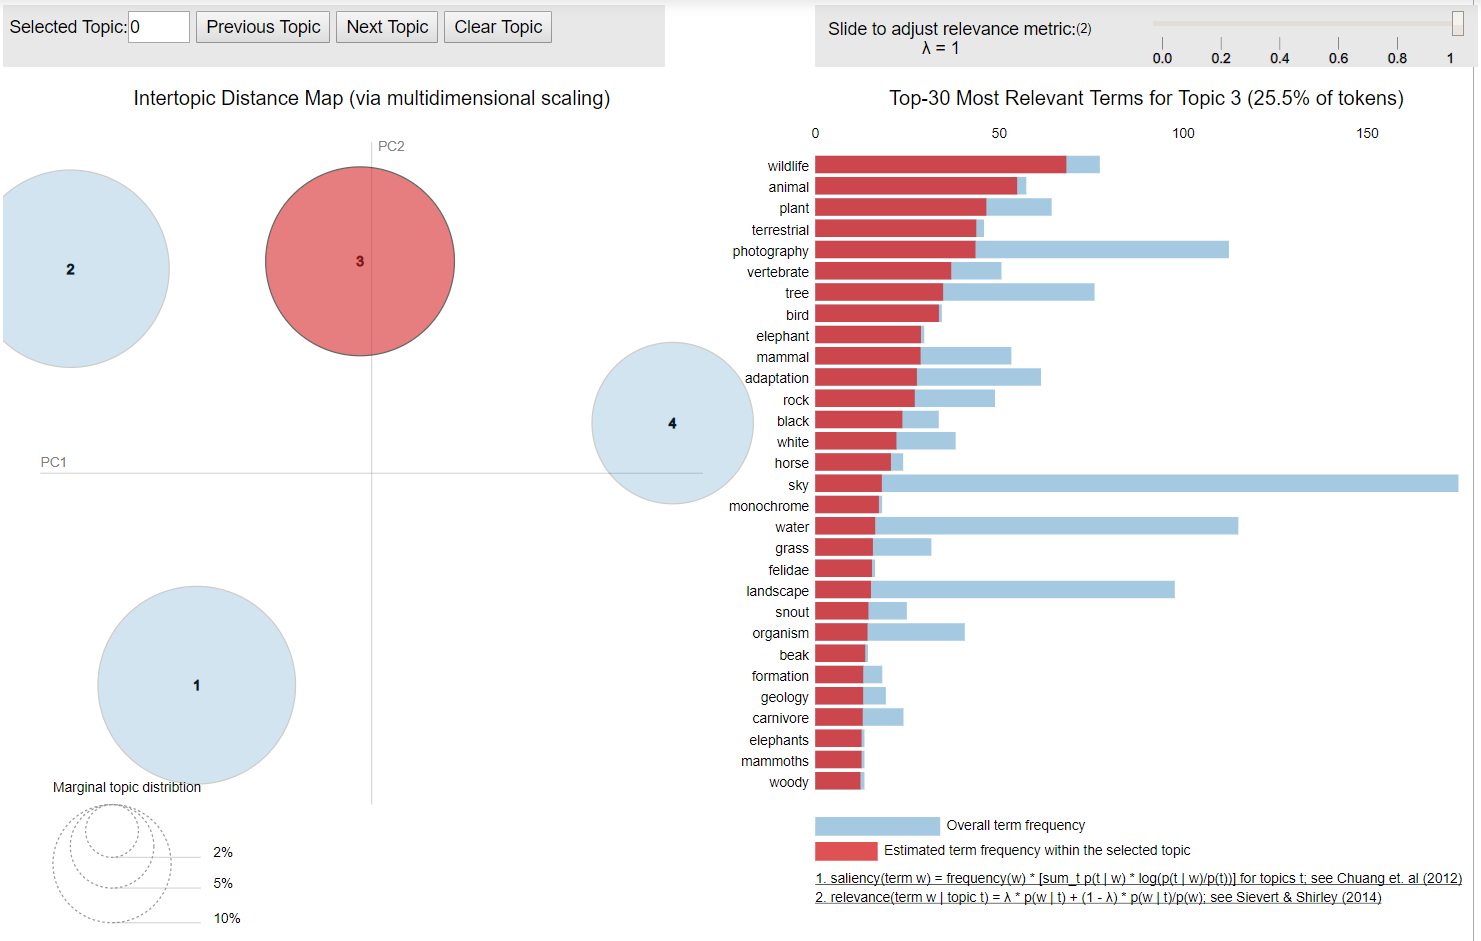

In [26]:
from IPython.display import Image
Image(filename='pyLDAvis.png')

## Task D. What advice would you give National Geographic if it wants to increase engagement on its Instagram page based on your findings in Tasks B and C?   

Based on the topic modeling findings, if National Geographic wants to increase engagement, they should focus on posting pictures of animals, especially terrestrial animals. The posts which exhibit lower engagement on average are pictures of people, while the posts which exhibit higher engagement on average are posts of animals. 


The top ten key words associated with the topic which generated the highest engagement were “wildlife”, “animal”, “plant”, “terrestrial”, “photography”, “vertebrate”, “tree”, “bird”, “elephant”, and “mammal”. Perhaps there is so much content of people on Instagram that National Geographic differentiates itself through pictures of wildlife. This theory is further substantiated by the low engagement for posts that contain either people or more domestic content. The key words in the topic which generated the lowest engagement were “photography”, “fun”, “human”, “people”, “adaptation”, “event”, “dog”, “smile”, “child”, and “room”.


Currently, engagement can be successfully predicted by the content of the captions, suggesting their importance. However, no additional information is gained by including both the photo labels and the captions. This seems to indicate that National Geographic is typically reiterating the content in the photo again in the caption. The company could try some A/B Testing with captions that include other insights related to the picture without reiterating the photo’s content to see if there is an impact on engagement. However, this should be considered a secondary priority, as the effects on engagement are uncertain. 
